In [1]:
import sfaira
import copy
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import anndata2ri
from rpy2.robjects import r

In [2]:
anndata2ri.activate()
sc.set_figure_params(dpi=150)

In [3]:
def harmonize_featurespace(adata):
    ds = sfaira.data.DatasetInteractive(
        data=adata,
        feature_symbol_col="index", # var column containing gene names
        feature_id_col=None, # var column containing ensembl ids
    )
    ds.organism = "Homo sapiens"
    ds.streamline_var(match_to_release="104", subset_genes_to_type=["protein_coding", "lncRNA"])
    return ds.adata

In [4]:
# download link: https://ftp.ncbi.nlm.nih.gov/geo/series/GSE233nnn/GSE233574/suppl/GSE233574%5FOrganoidScreen%5Fprocessed%5FSeuratObject%2Erds%2Egz
fn = "/storage/data/sfaira_data/raw/dno_doi_pasca/GSE233574_OrganoidScreen_processed_SeuratObject.rds"
adata1 = r(
    f"library(Seurat)\n"
    f"as.SingleCellExperiment(readRDS('{fn}'), assay='RNA')\n"
)

# download link: https://ftp.ncbi.nlm.nih.gov/geo/series/GSE233nnn/GSE233574/suppl/GSE233574%5FOrganoid%2ESAG%2EsecondaryScreen%5Fprocessed%5FSeuratObject%2Erds%2Egz
fn2 = "/storage/data/sfaira_data/raw/dno_doi_pasca/GSE233574_Organoid.SAG.secondaryScreen_processed_SeuratObject.rds"
adata2 = r(
    f"library(Seurat)\n"
    f"as.SingleCellExperiment(readRDS('{fn2}'), assay='RNA')\n"
)

# download link: https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM7430nnn/GSM7430748/suppl/GSM7430748%5FHumanFetalStriatum%5FSeuratObject%2Erds%2Egz
fn3 = "/storage/data/sfaira_data/raw/dno_doi_pasca/GSM7430748_HumanFetalStriatum_SeuratObject.rds"
adata_fetal = r(
    f"library(Seurat)\n"
    f"as.SingleCellExperiment(readRDS('{fn3}'), assay='RNA')\n"
)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    


/home/ubuntu/venv/organoids/lib/python3.10/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)
/home/ubuntu/venv/organoids/lib/python3.10/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)
/home/ubuntu/venv/organoids/lib/python3.10/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will no

In [5]:
adata1

AnnData object with n_obs × n_vars = 36265 × 29910
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'tscp_count', 'tscp_count_50dup', 'gene_count', 'percent_mt', 'percent_ribo', 'percent_chrY', 'percent_chrX', 'condition', 'seurat_clusters', 'class', 'class2', 'region', 'ident'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [6]:
adata2

AnnData object with n_obs × n_vars = 4724 × 33289
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_well', 'bc2_well', 'bc3_well', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'percent_mt', 'percent_ribo', 'percent_chrY', 'percent_chrX', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'condition', 'ClusterLabel', 'ident'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [7]:
adata_fetal

AnnData object with n_obs × n_vars = 5530 × 23260
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Hs.percent.chrY', 'Hs.percent.chrX', 'Hs.percent.ribo', 'Hs.percent.mito', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'ClusterLabel', 'ident'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [8]:
adata2.obs["class"] = "unknown"
adata2.obs["class2"] = adata2.obs["ClusterLabel"]
adata2.obs["region"] = "unknown"

adata_fetal.obs["class"] = "unknown"
adata_fetal.obs["class2"] = adata_fetal.obs["ClusterLabel"]
adata_fetal.obs["region"] = "unknown"
adata_fetal.obs["condition"] = "na"

In [9]:
adata1 = harmonize_featurespace(adata1)
adata2 = harmonize_featurespace(adata2)
adata_fetal = harmonize_featurespace(adata_fetal)

transformed feature space on interactive_dataset: 
log10 total counts 8.43 to 8.4, non-zero features 29910 to 19644
transformed feature space on interactive_dataset: 
log10 total counts 7.9 to 7.87, non-zero features 32342 to 19915
transformed feature space on interactive_dataset: 
log10 total counts 7.74 to 7.73, non-zero features 23257 to 17614


In [10]:
adata = ad.concat([adata1, adata2, adata_fetal], label="dataset", keys=["organoid_screen", "secondary_organoid_screen", "fetal_striatum_21pcw"])

/home/ubuntu/venv/organoids/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
adata.var = adata1.var.set_index("gene_symbol", drop=False)
adata.var.index.name = None
adata.var_names_make_unique()

In [12]:
adata.obs_names_make_unique()

In [13]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

In [14]:
adata.write("/storage/data/organoid_atlas_adatas/230605_pasca_all_01.h5ad", compression="gzip")

/home/ubuntu/venv/organoids/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/ubuntu/venv/organoids/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


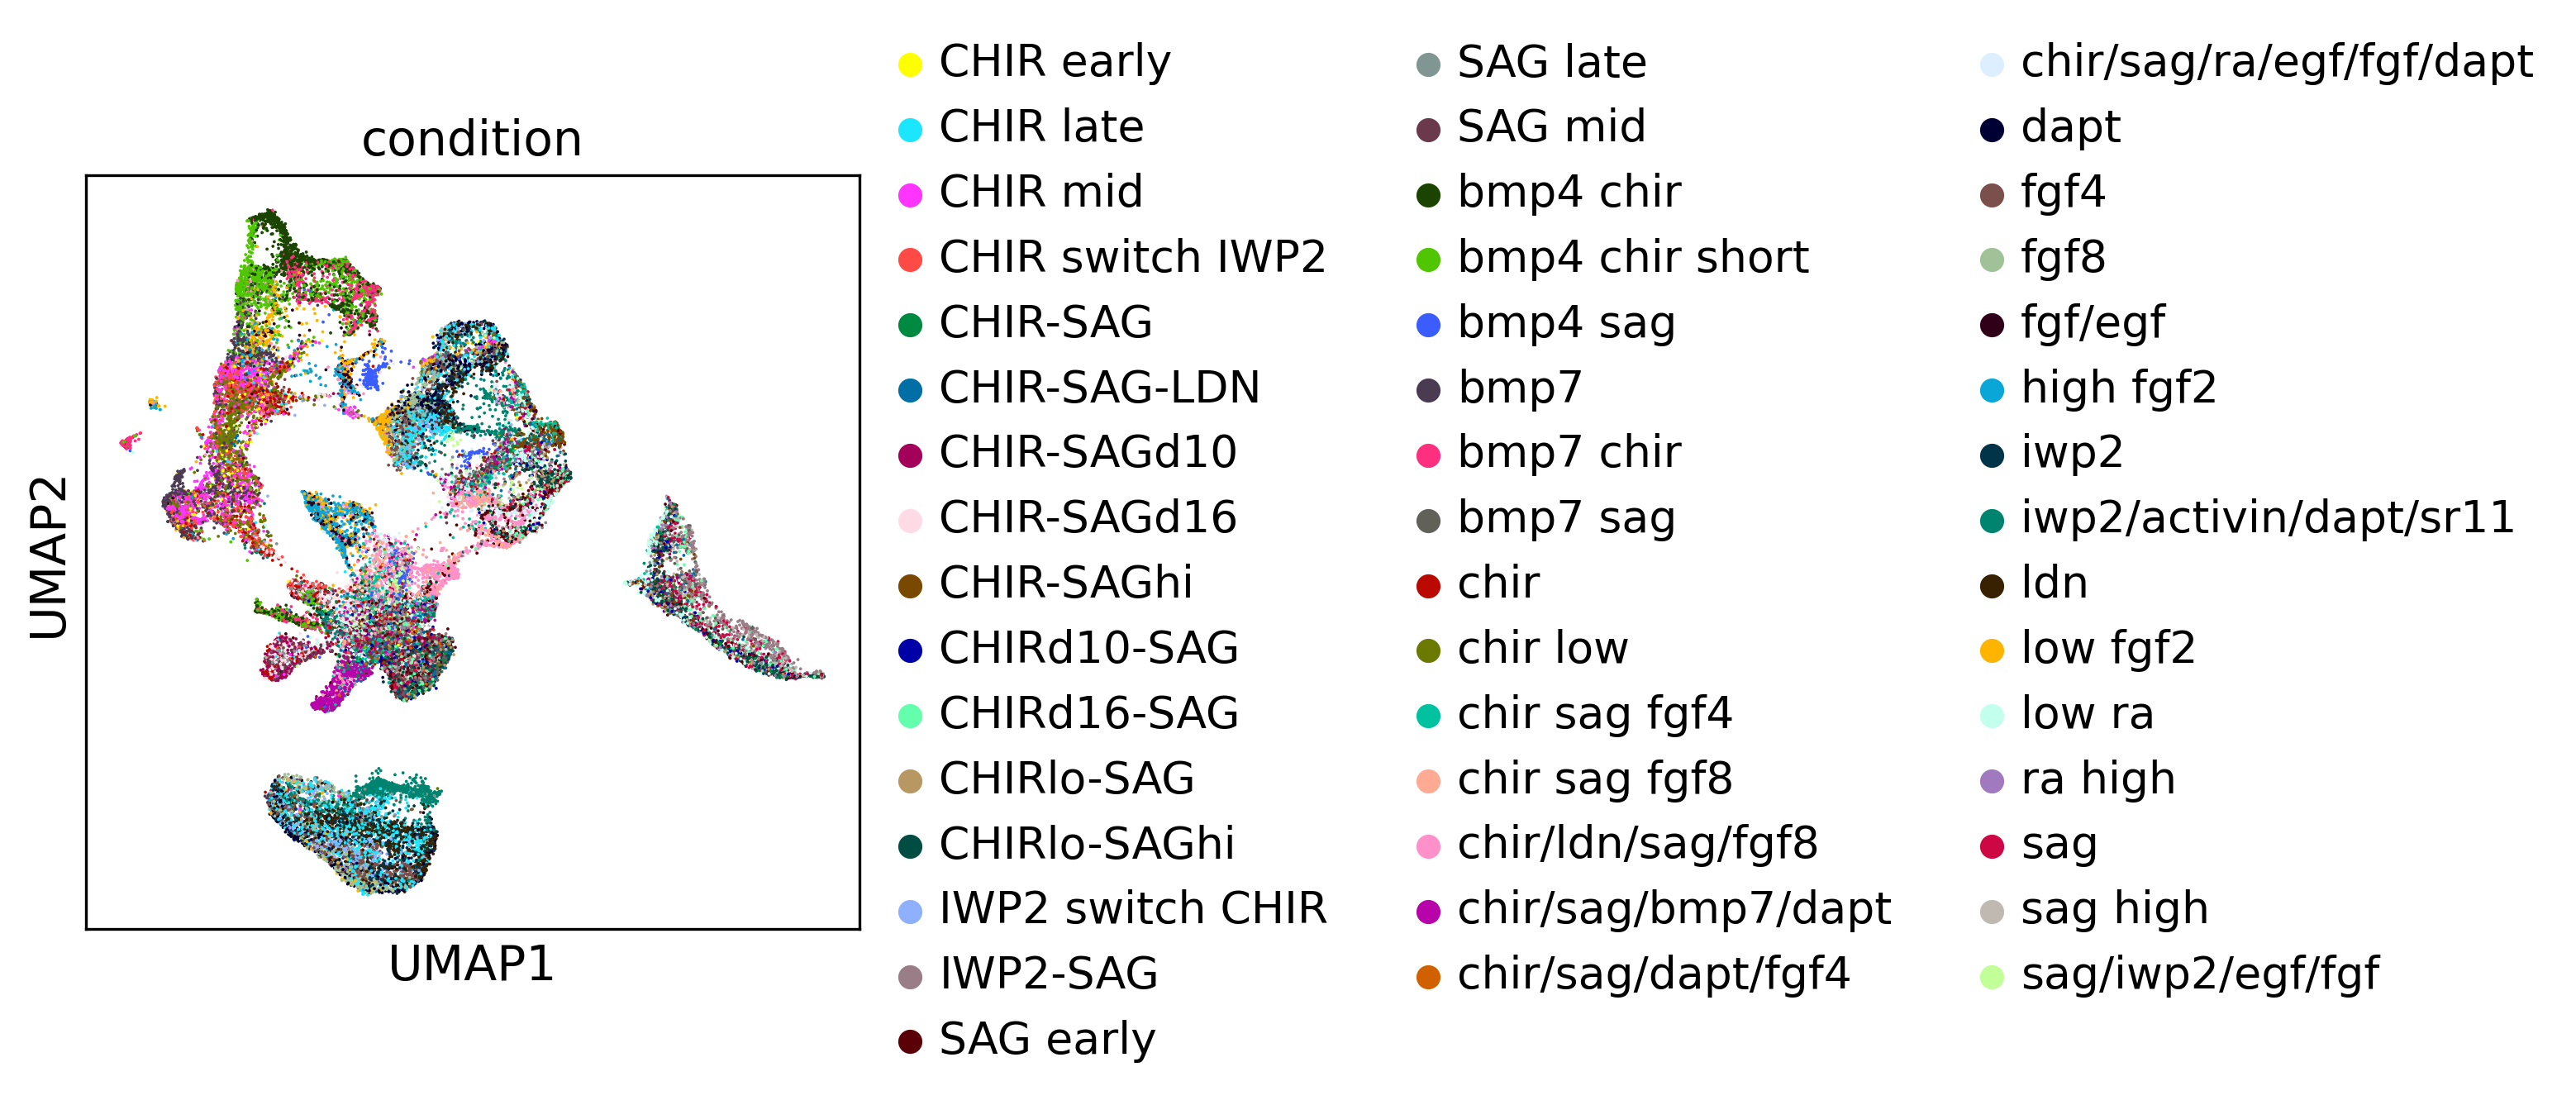

/home/ubuntu/venv/organoids/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/ubuntu/venv/organoids/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


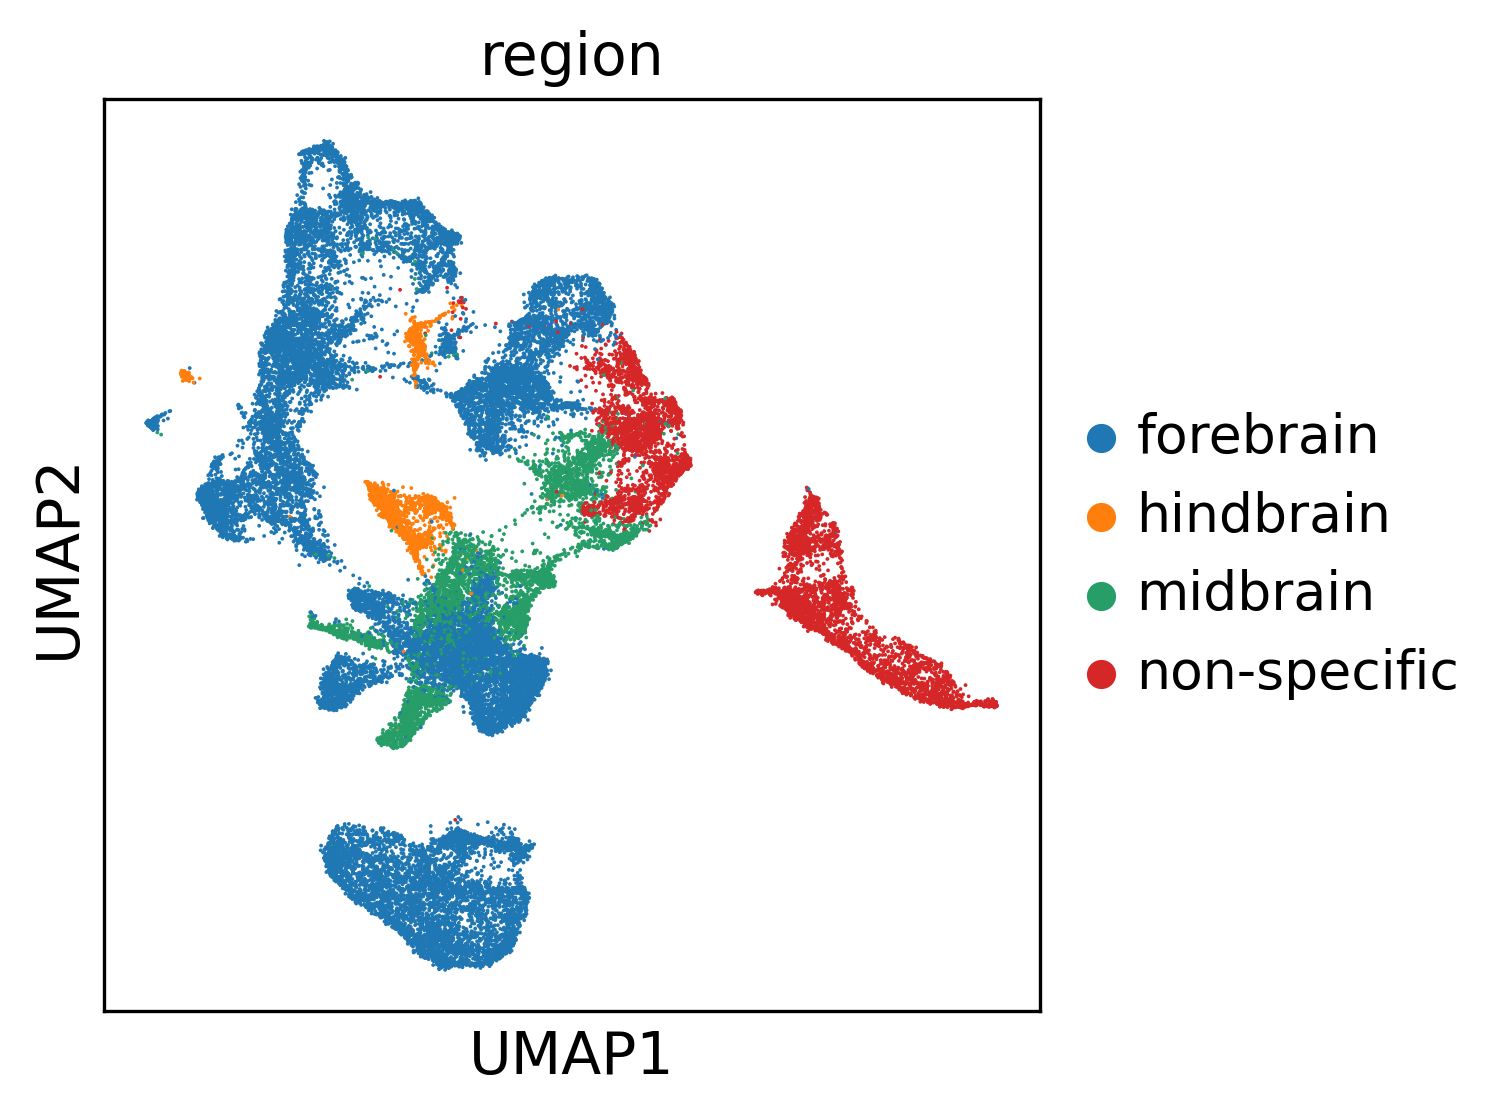

/home/ubuntu/venv/organoids/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/ubuntu/venv/organoids/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


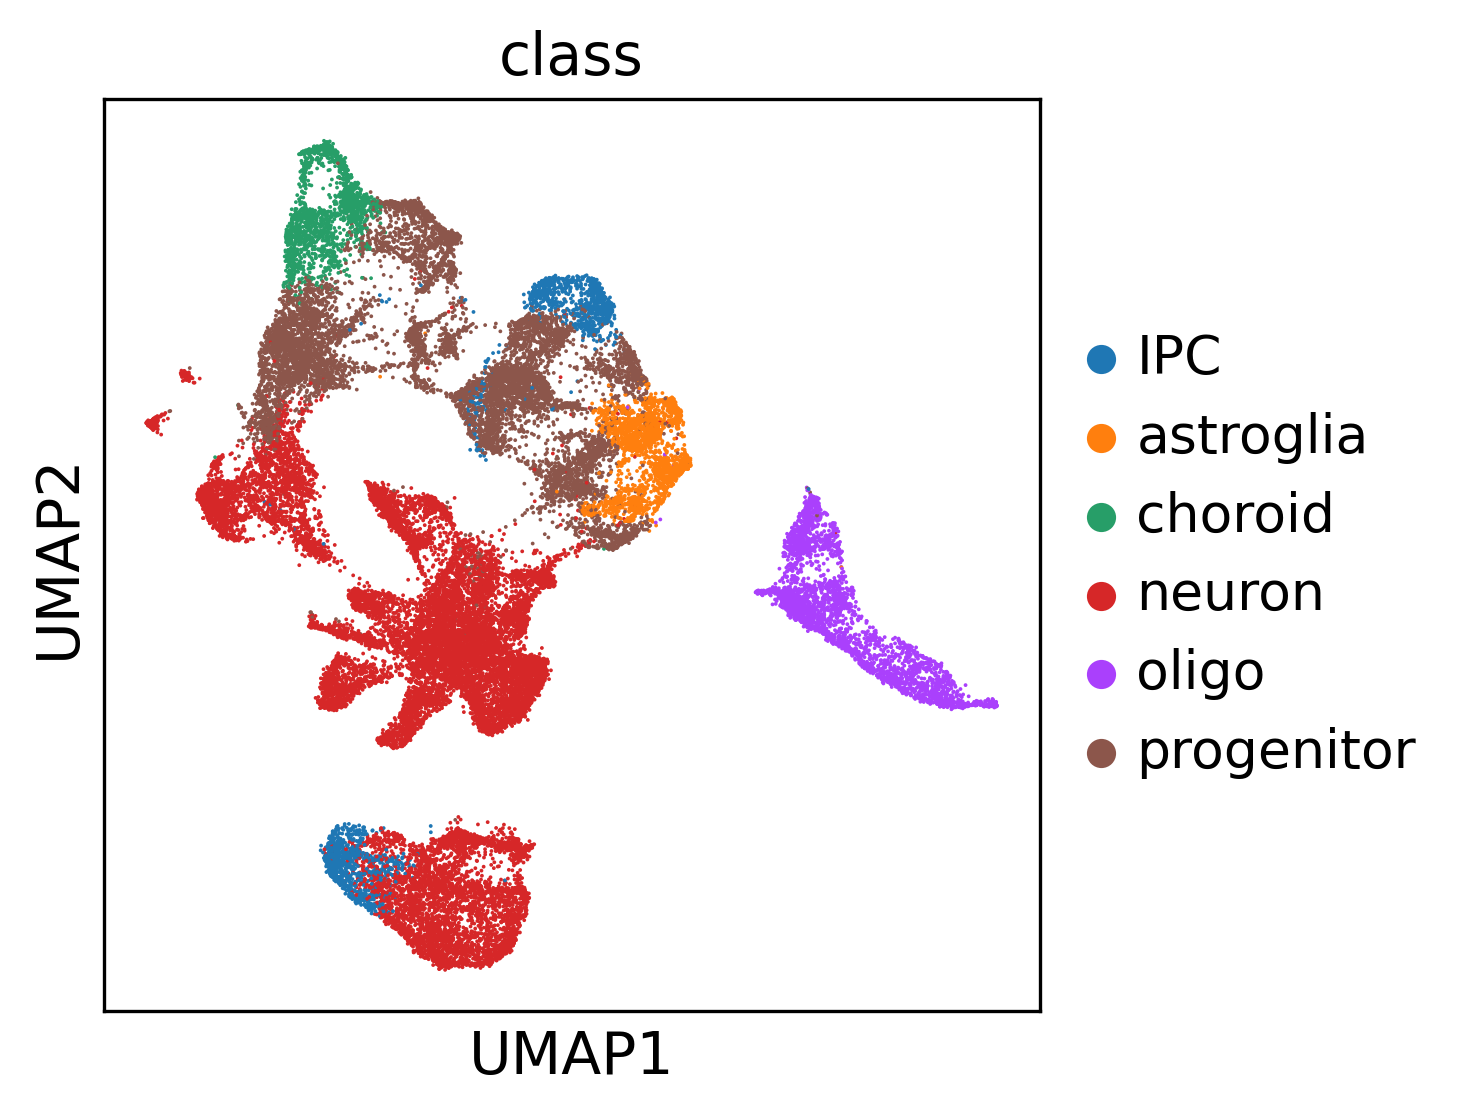

/home/ubuntu/venv/organoids/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/ubuntu/venv/organoids/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


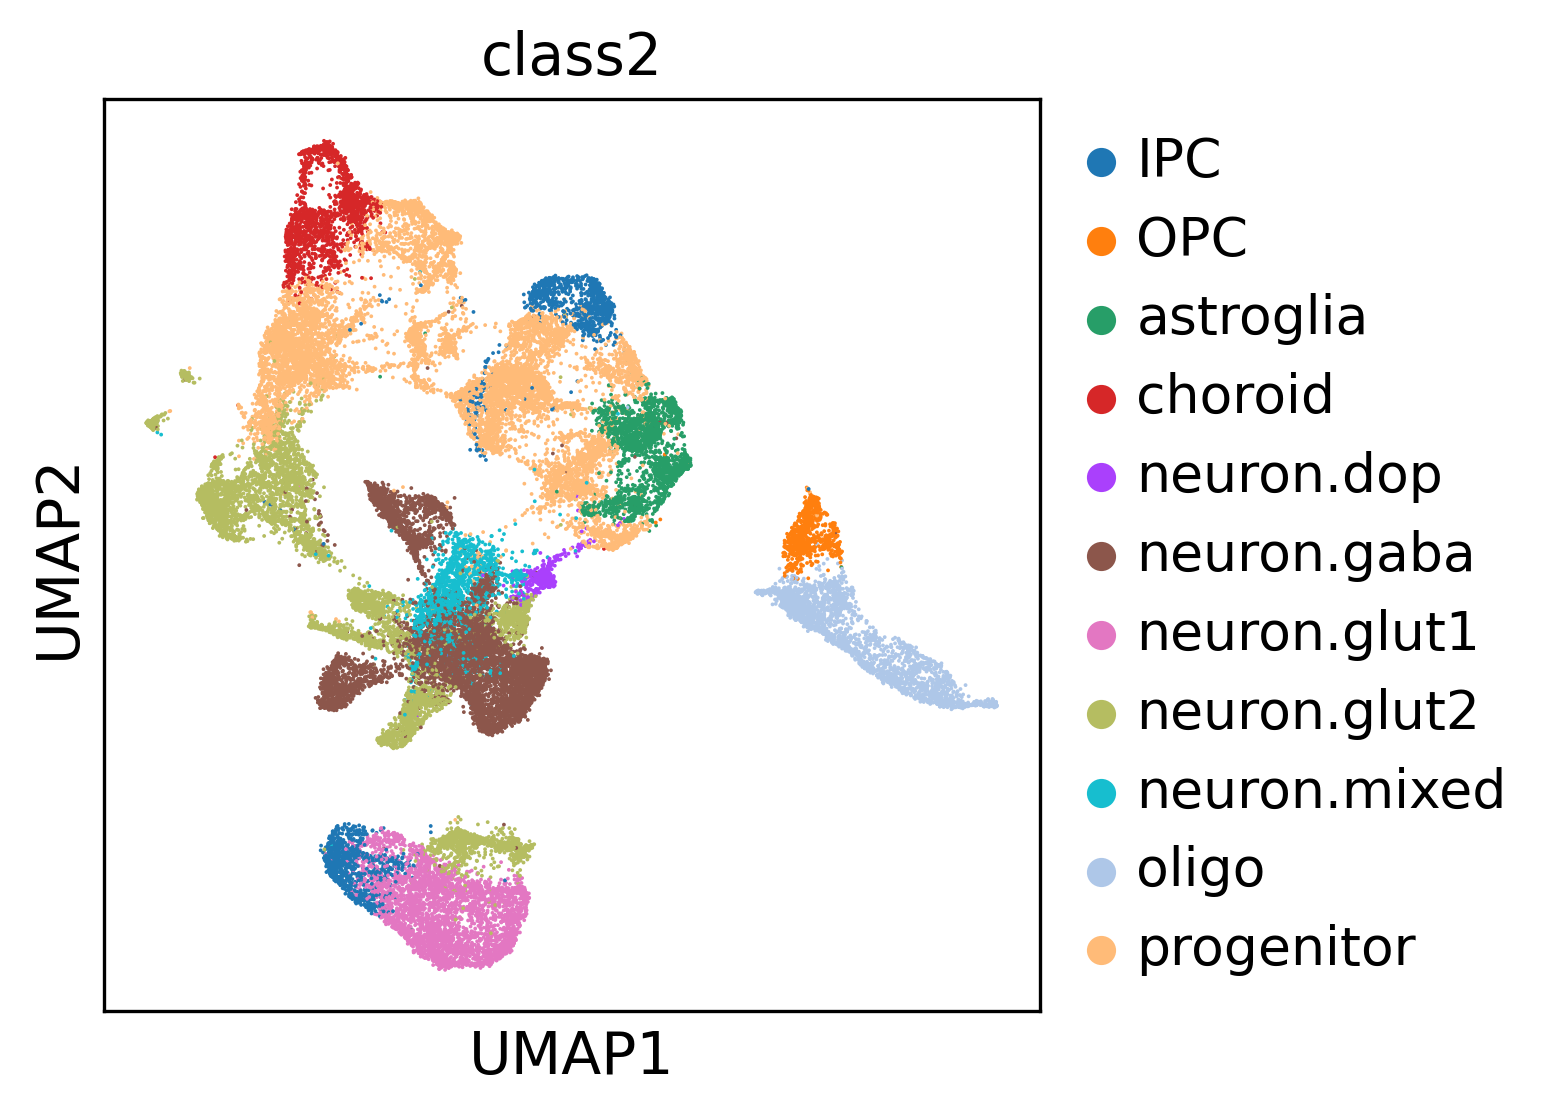

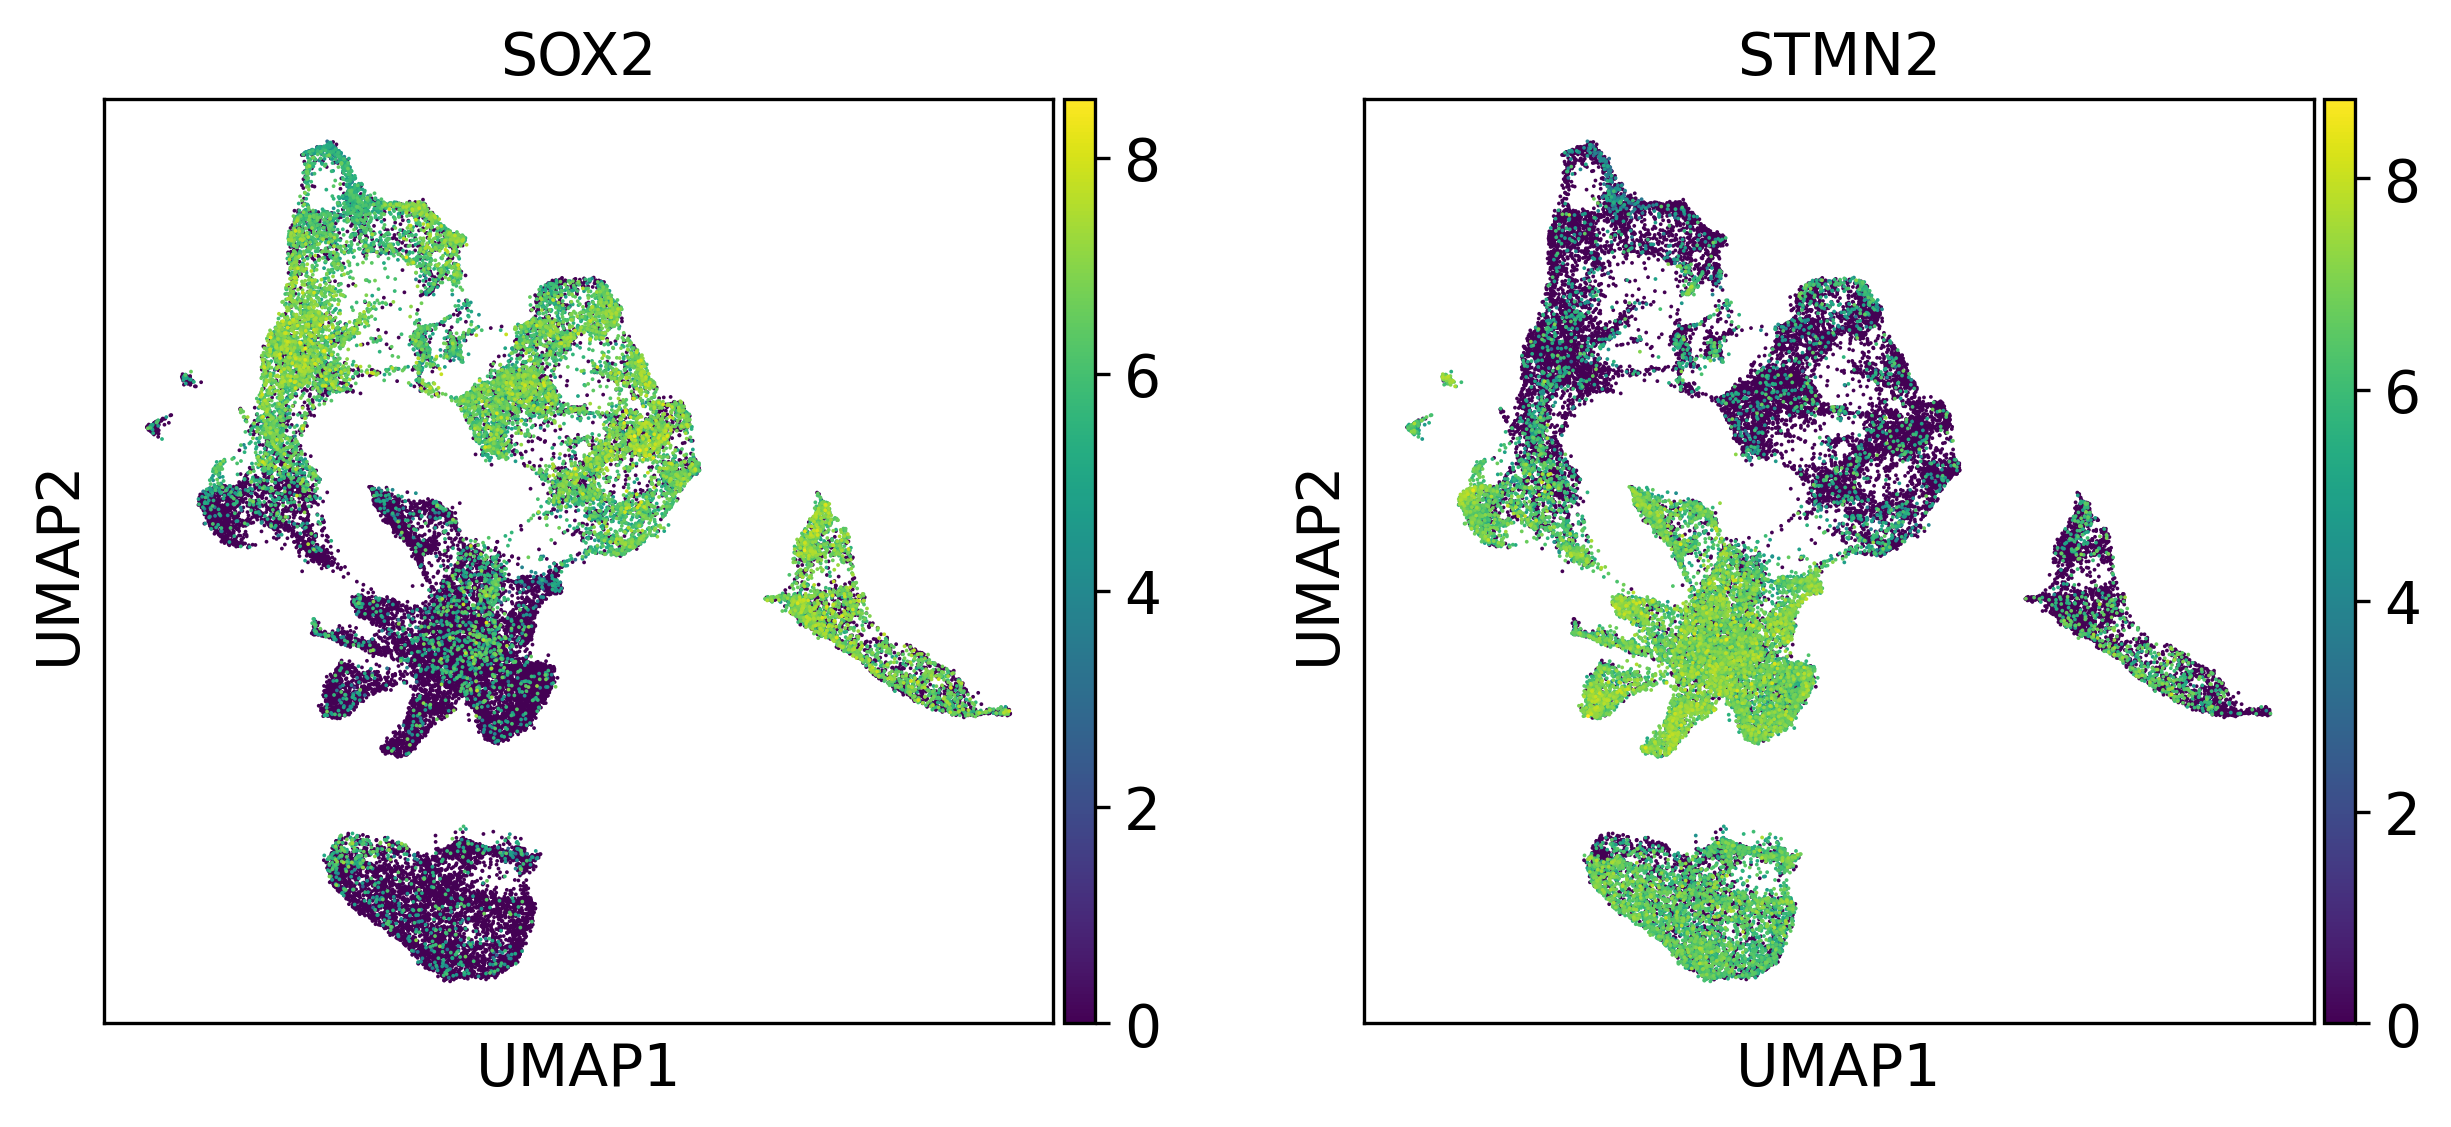

In [15]:
sc.pl.umap(adata[adata.obs["dataset"] == "organoid_screen"], color=["condition"])
sc.pl.umap(adata[adata.obs["dataset"] == "organoid_screen"], color=["region"])
sc.pl.umap(adata[adata.obs["dataset"] == "organoid_screen"], color=["class"])
sc.pl.umap(adata[adata.obs["dataset"] == "organoid_screen"], color=["class2"])
sc.pl.umap(adata[adata.obs["dataset"] == "organoid_screen"], color=["SOX2", "STMN2"])

/home/ubuntu/venv/organoids/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/ubuntu/venv/organoids/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


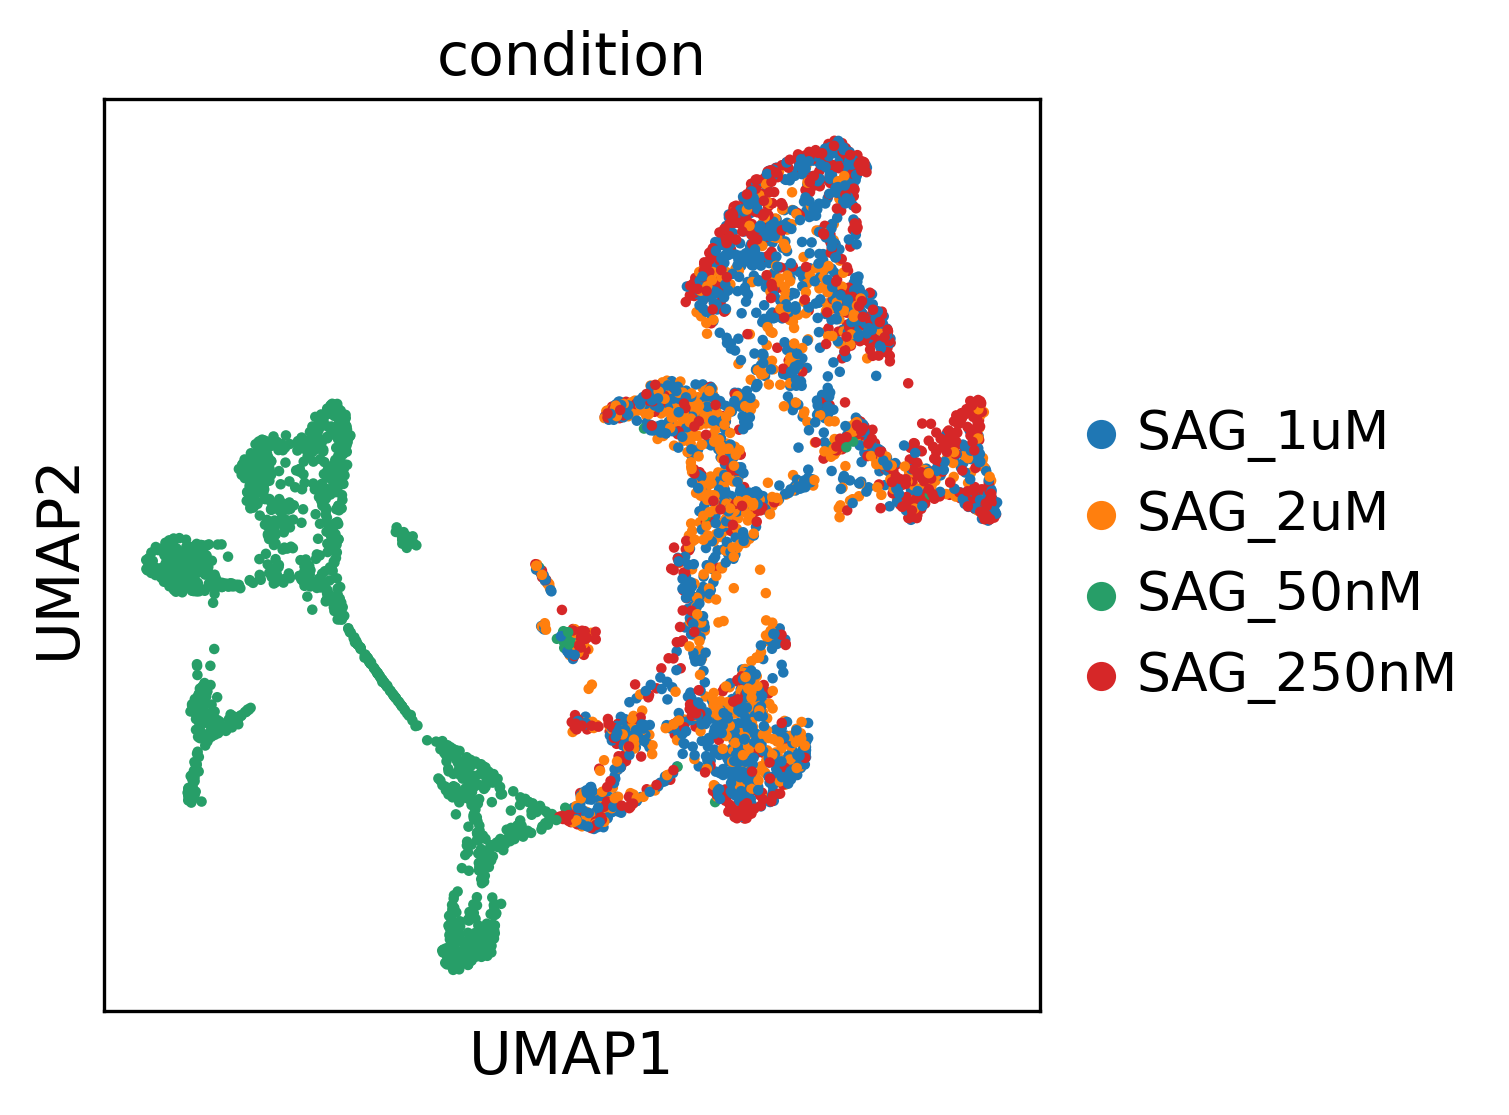

/home/ubuntu/venv/organoids/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/ubuntu/venv/organoids/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


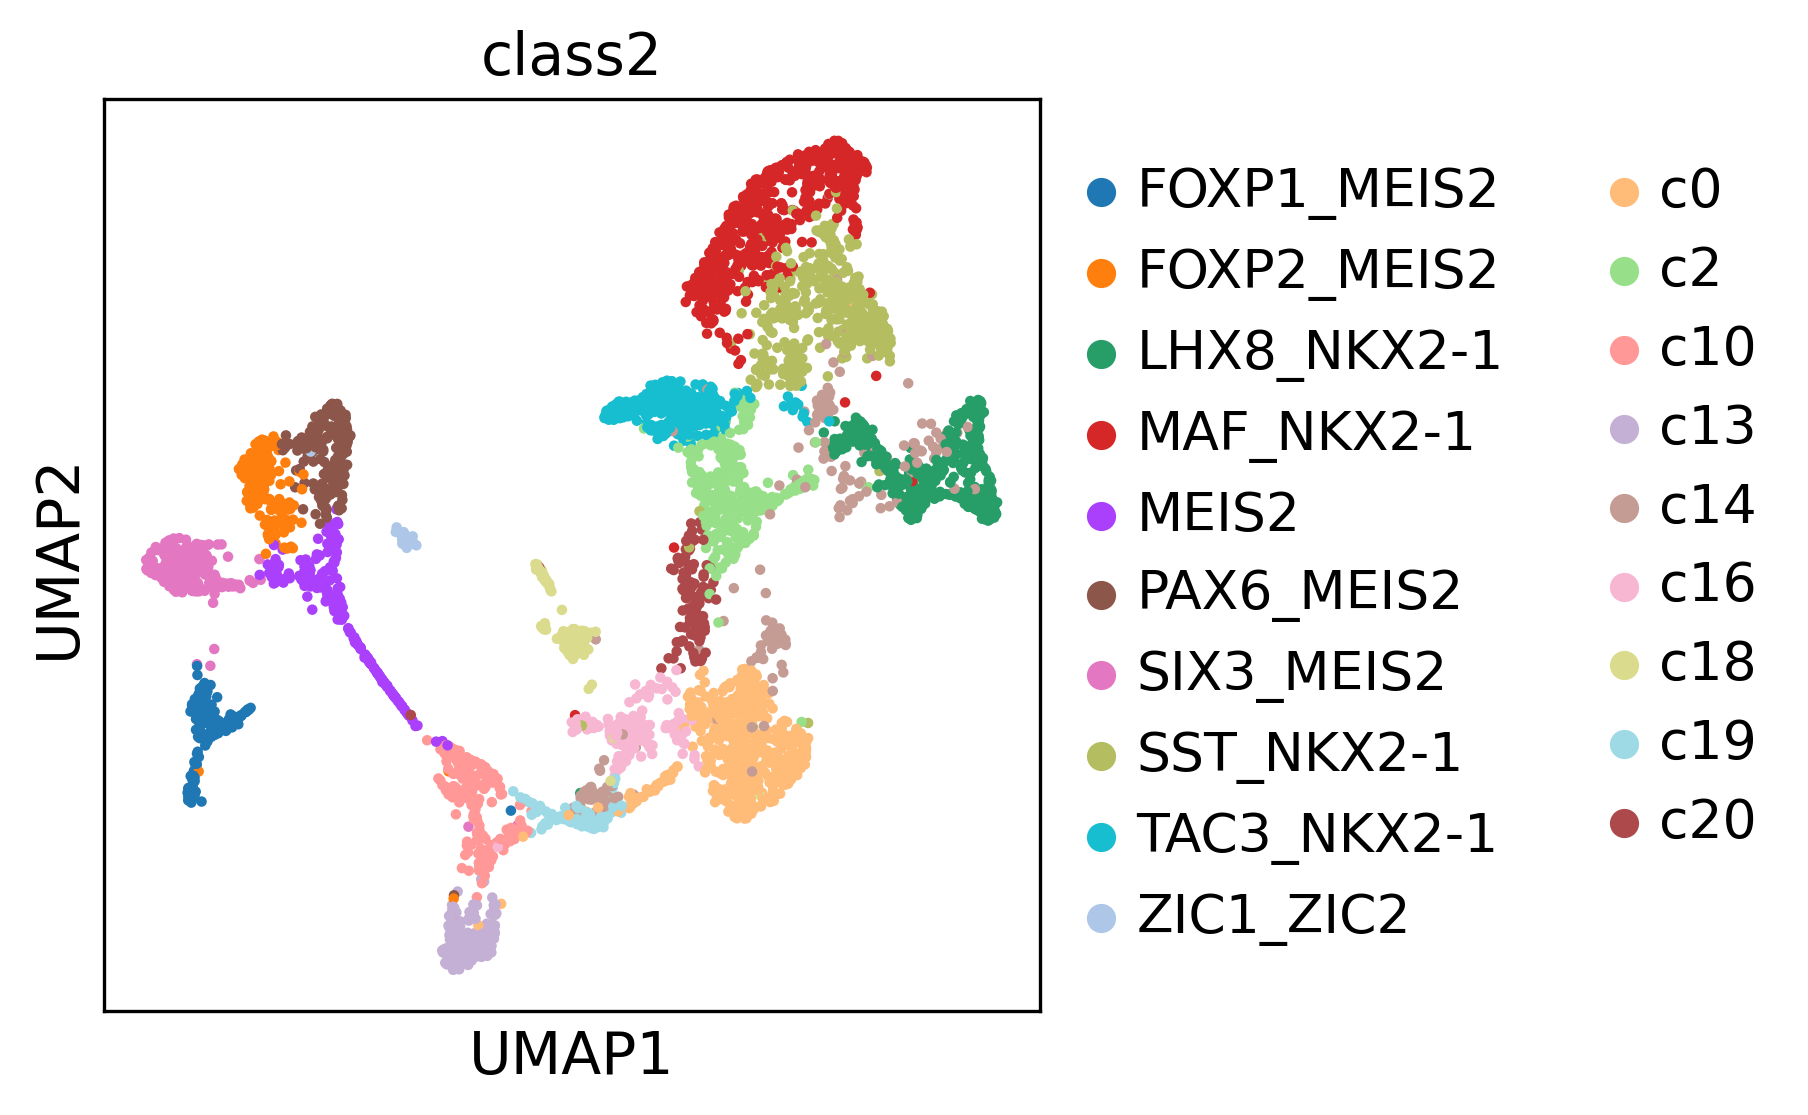

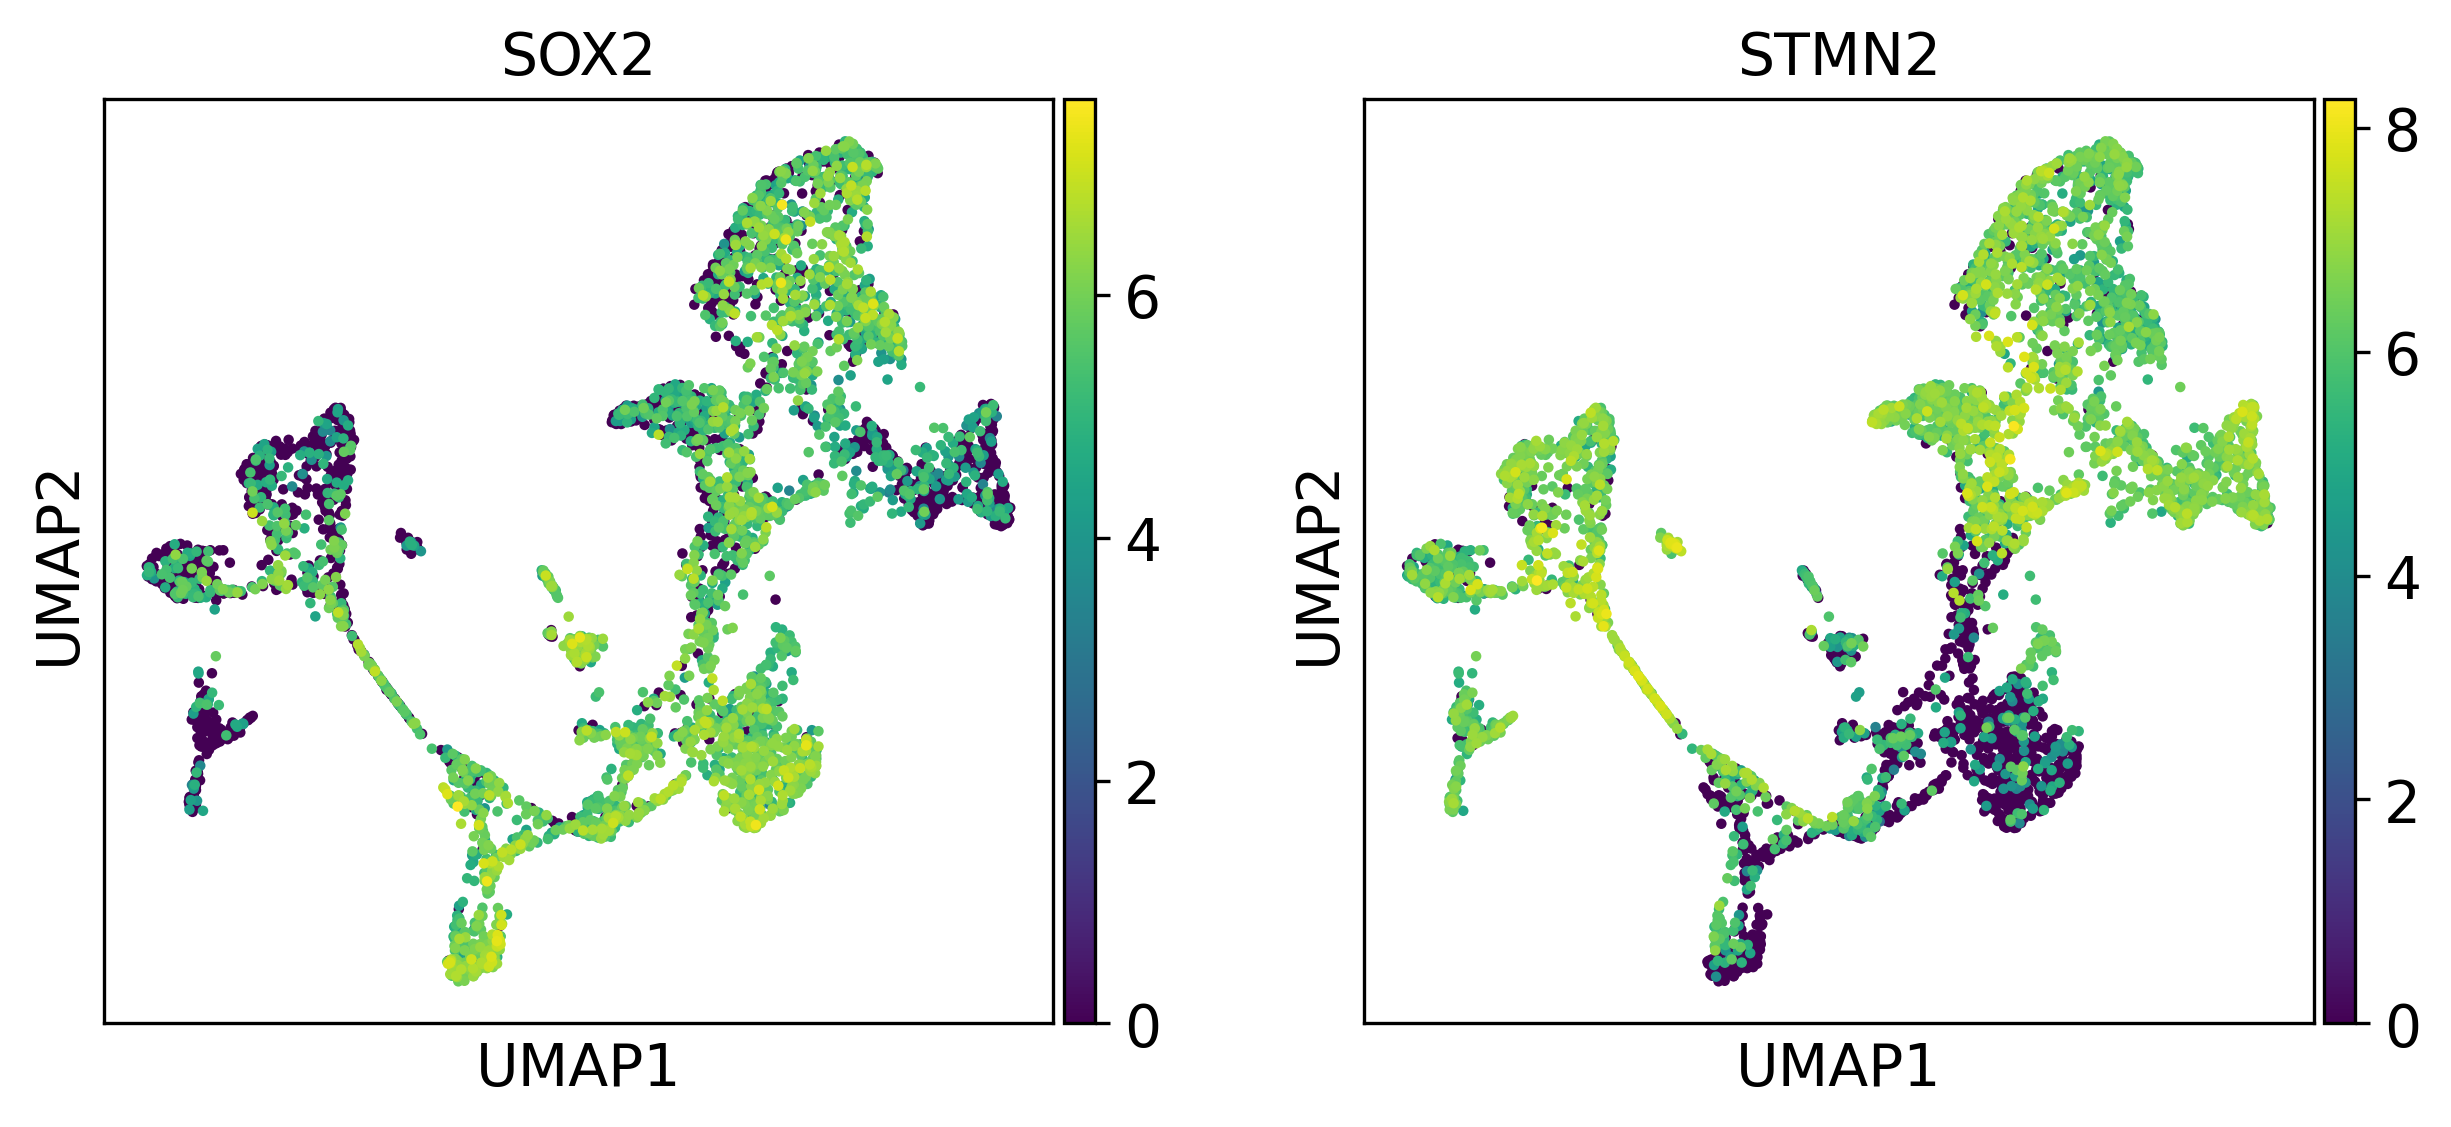

In [16]:
sc.pl.umap(adata[adata.obs["dataset"] == "secondary_organoid_screen"], color=["condition"])
sc.pl.umap(adata[adata.obs["dataset"] == "secondary_organoid_screen"], color=["class2"])
sc.pl.umap(adata[adata.obs["dataset"] == "secondary_organoid_screen"], color=["SOX2", "STMN2"])

/home/ubuntu/venv/organoids/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/ubuntu/venv/organoids/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


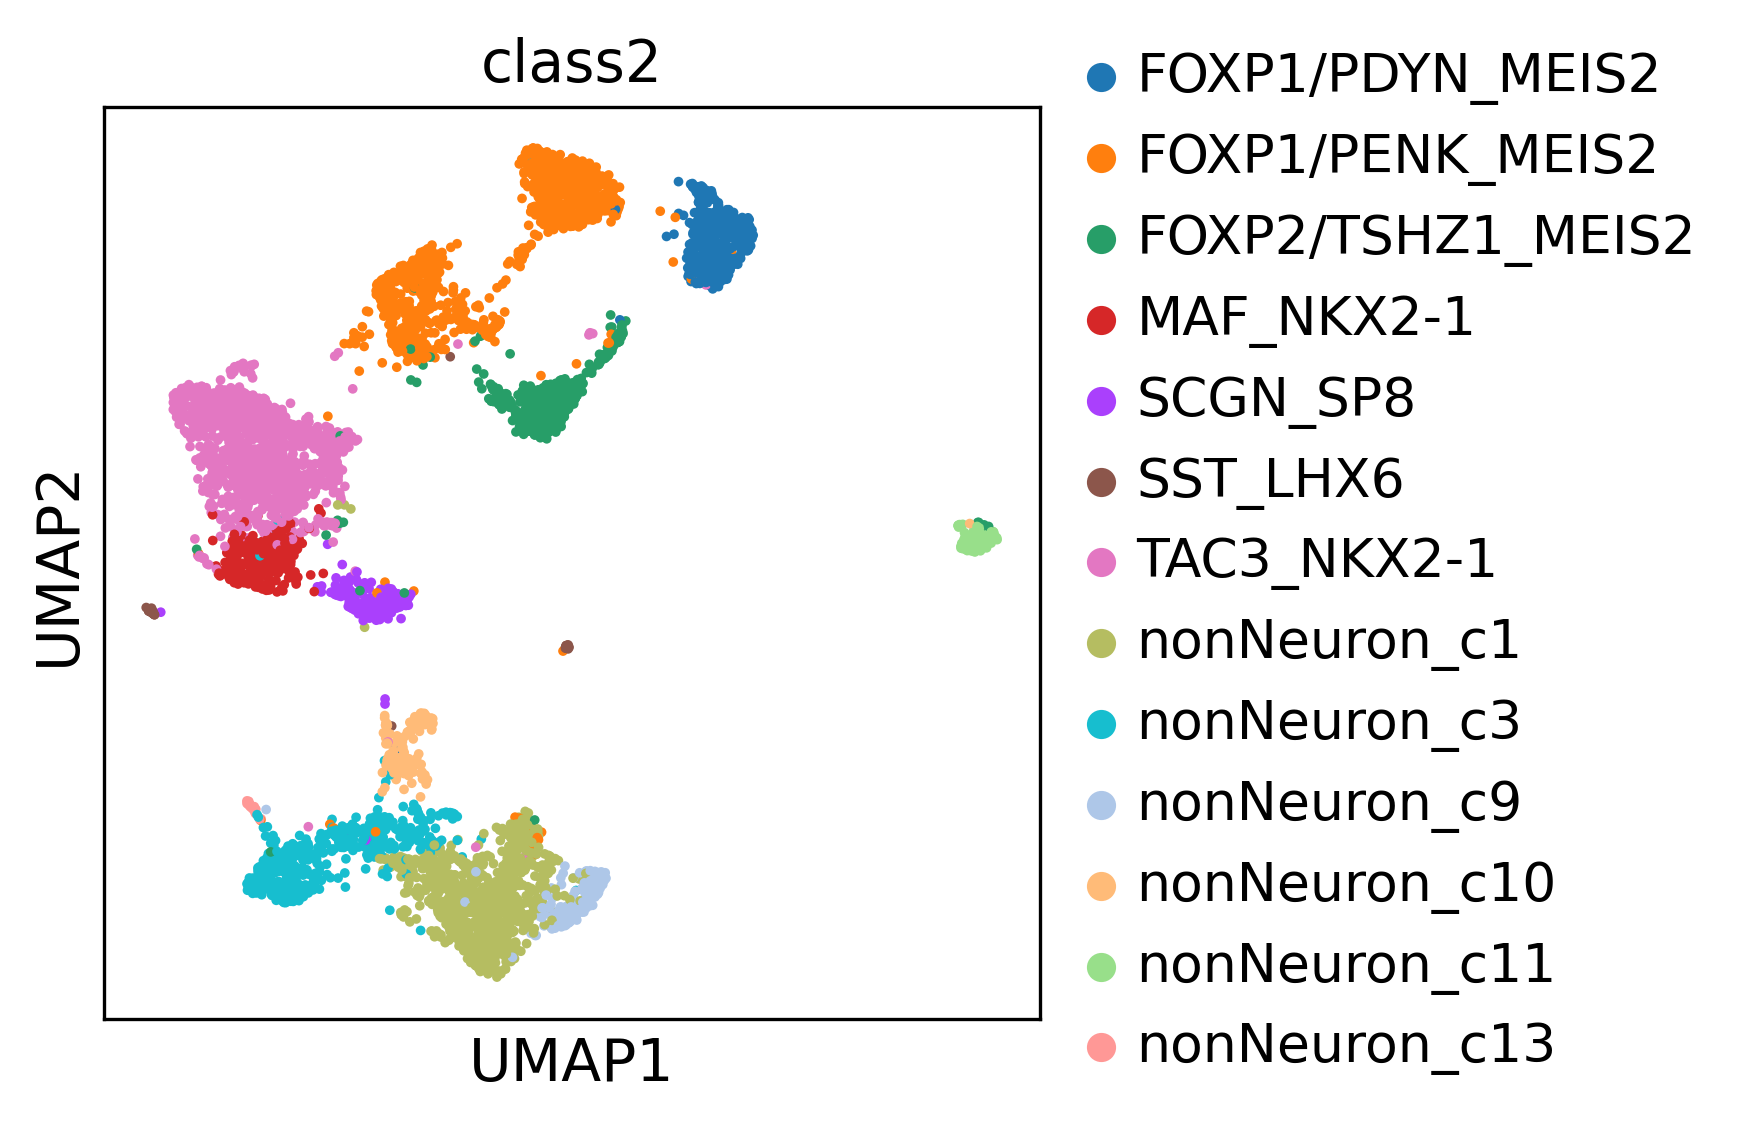

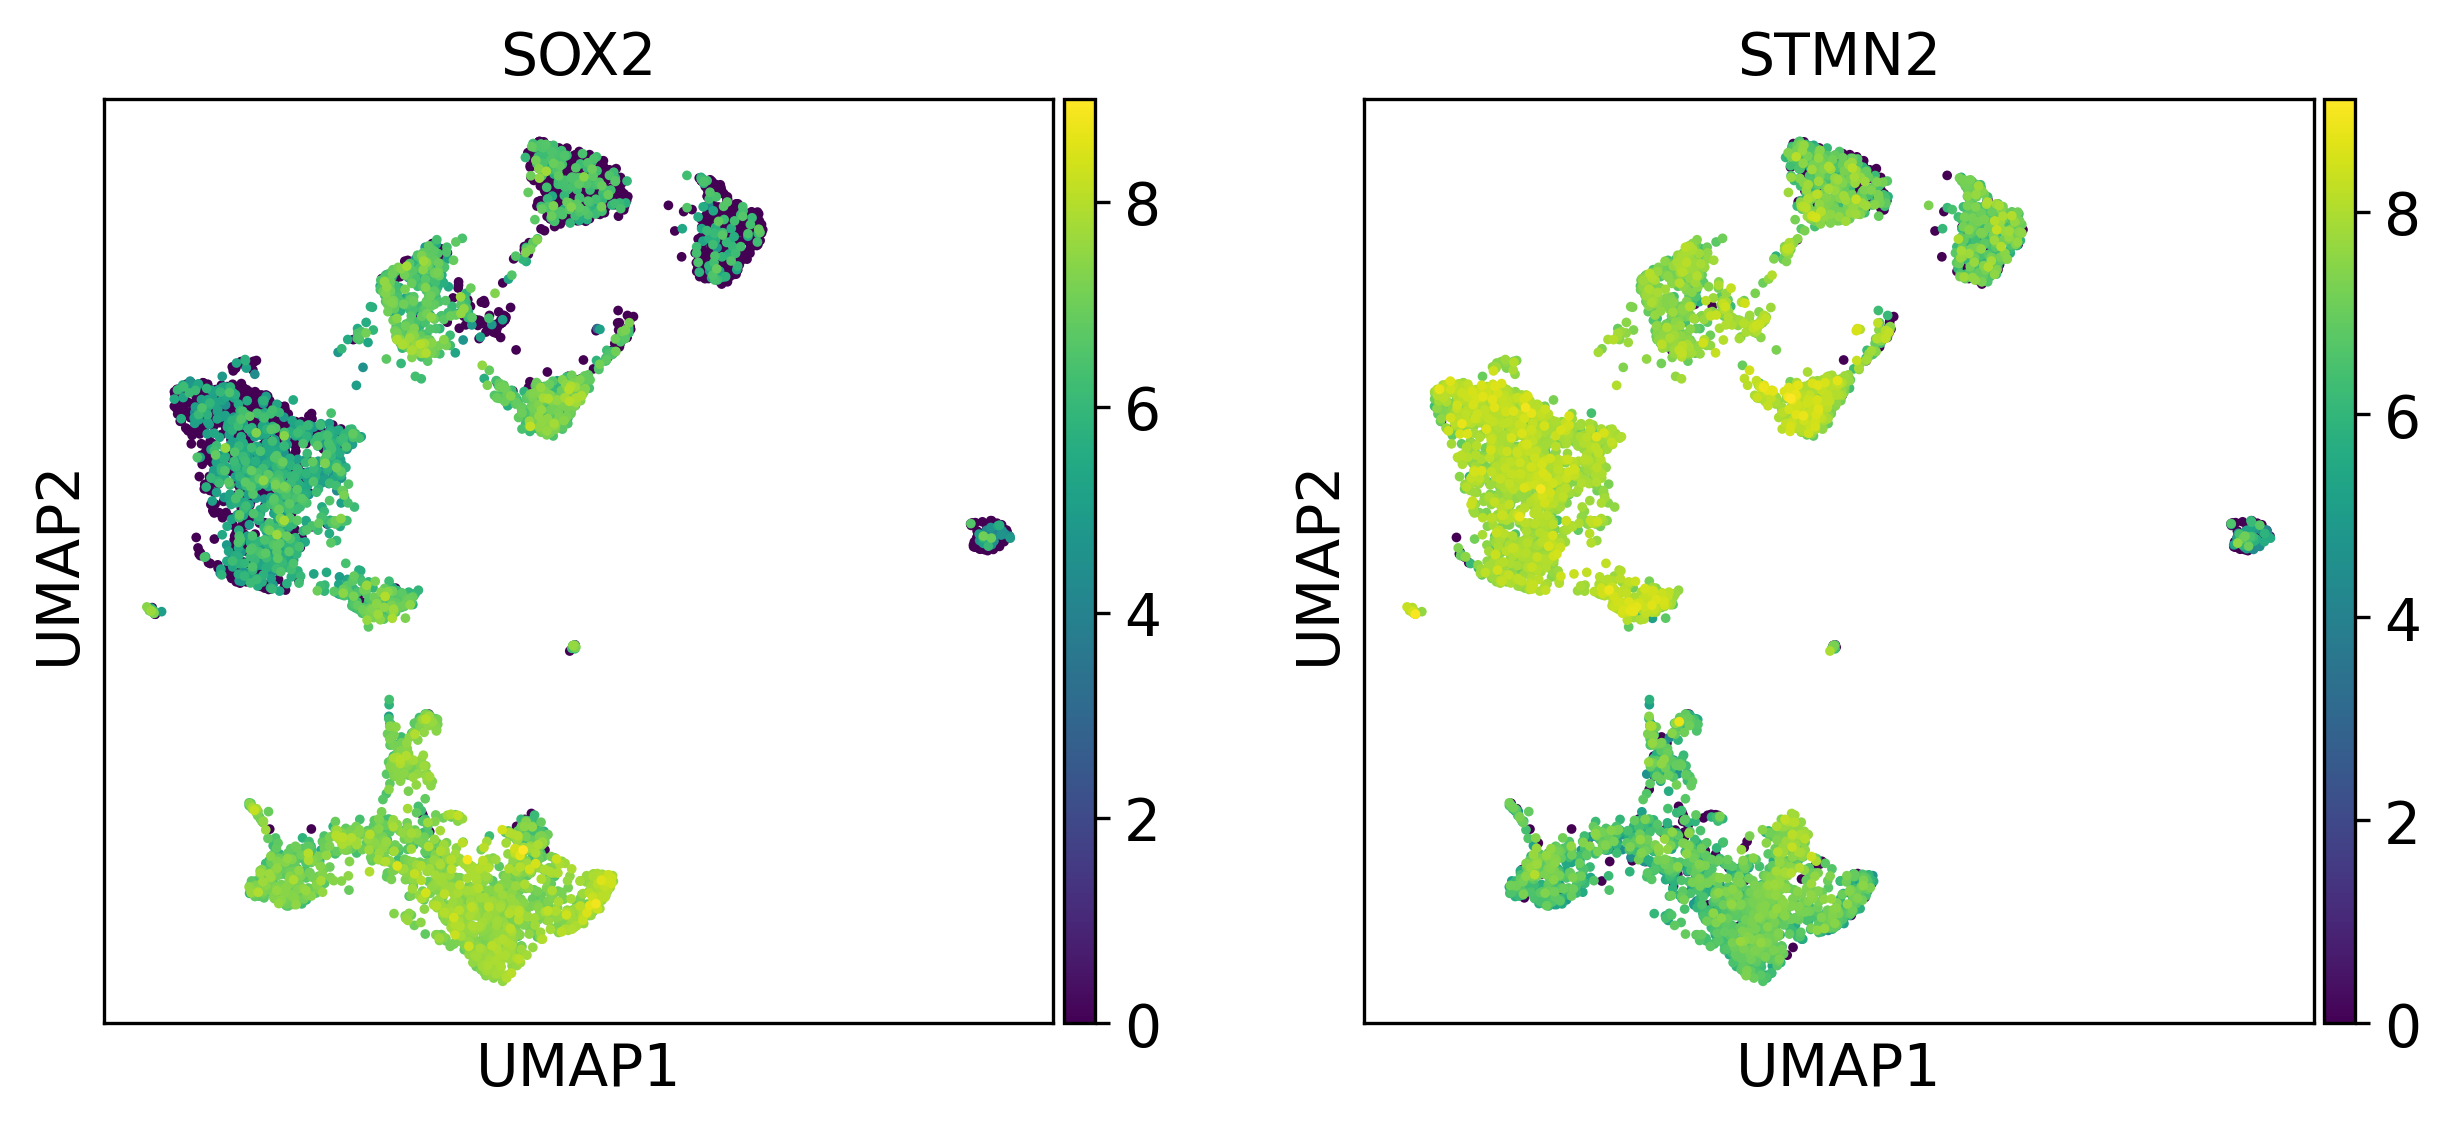

In [17]:
sc.pl.umap(adata[adata.obs["dataset"] == "fetal_striatum_21pcw"], color=["class2"])
sc.pl.umap(adata[adata.obs["dataset"] == "fetal_striatum_21pcw"], color=["SOX2", "STMN2"])